In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
import os

data_dir = './jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

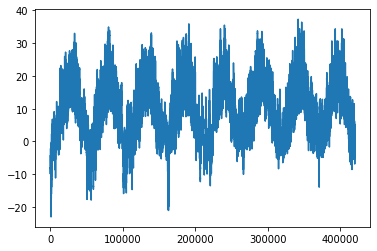

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

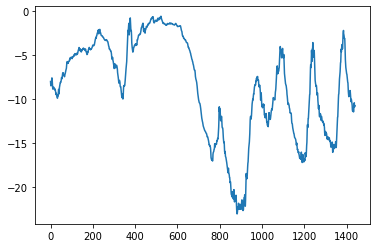

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.1490 - val_loss: 0.4738
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4098 - val_loss: 0.2990
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2942 - val_loss: 0.2603
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2681 - val_loss: 0.2146
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2559 - val_loss: 0.1803
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2445 - val_loss: 0.1751
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2394 - val_loss: 0.1210
Epoch 8/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2339 - val_loss: 0.1825
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2301 - val_loss: 0.1550
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.225

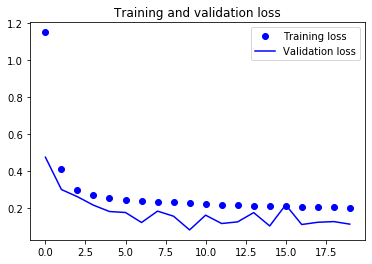

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 112s 223ms/step - loss: 0.3095 - val_loss: 0.3148
Epoch 2/20
500/500 [==============================] - 134s 267ms/step - loss: 0.2860 - val_loss: 0.3196
Epoch 3/20
500/500 [==============================] - 152s 305ms/step - loss: 0.2775 - val_loss: 0.3496
Epoch 4/20
500/500 [==============================] - 205s 411ms/step - loss: 0.2733 - val_loss: 0.3137
Epoch 5/20
500/500 [==============================] - 179s 358ms/step - loss: 0.2703 - val_loss: 0.3291
Epoch 6/20
500/500 [==============================] - 151s 302ms/step - loss: 0.2637 - val_loss: 0.3482
Epoch 7/20
500/500 [==============================] - 145s 290ms/step - loss: 0.2569 - val_loss: 0.3329
Epoch 8/20
500/500 [==============================] - 136s 273ms/step - loss: 0.2545 - val_loss: 0.3394
Epoch 9/20
500/500 [==============================] - 145s 290ms/step - loss: 0.2495 - val_loss: 0.3761
Epoch 10/20
500/500 [==============================] - 150s 300m

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss'])

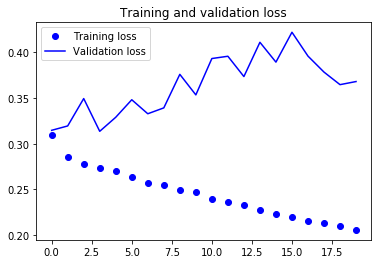

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 218s 436ms/step - loss: 0.3052 - val_loss: 0.2701
Epoch 2/20
500/500 [==============================] - 123s 246ms/step - loss: 0.2763 - val_loss: 0.1911
Epoch 3/20
500/500 [==============================] - 118s 237ms/step - loss: 0.2668 - val_loss: 0.2577
Epoch 4/20
500/500 [==============================] - 170s 340ms/step - loss: 0.2558 - val_loss: 0.2401
Epoch 5/20
500/500 [==============================] - 157s 313ms/step - loss: 0.2487 - val_loss: 0.0875
Epoch 6/20
500/500 [==============================] - 121s 241ms/step - loss: 0.2392 - val_loss: 0.2331
Epoch 7/20
500/500 [==============================] - 146s 292ms/step - loss: 0.2312 - val_loss: 0.1592
Epoch 8/20
500/500 [==============================] - 166s 331ms/step - loss: 0.2260 - val_loss: 0.1526
Epoch 9/20
500/500 [==============================] - 108s 215ms/step - loss: 0.2195 - val_loss: 0.1701
Epoch 10/20
500/500 [==============================] - 93s 186ms

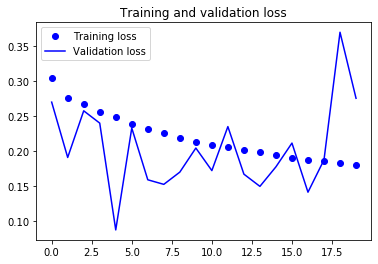

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [54]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *


# early = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=.01, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
tboard = keras.callbacks.TensorBoard(log_dir='Logs', histogram_freq=0, write_graph=True, write_images=True, profile_batch = 100000000)
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer='RMSprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=[tboard,checkpoint]
                             )


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3085 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2847 - val_loss: 0.2681
Epoch 3/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2800 - val_loss: 0.2667
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2749 - val_loss: 0.2740
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2678 - val_loss: 0.2640
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2650 - val_loss: 0.2628
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2629 - val_loss: 0.2644
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2581 - val_loss: 0.2657
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2547 - val_l

In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

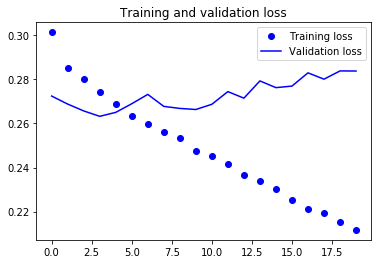

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()